In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

pd.set_option('display.max_columns', None)
save_loc = 'C:\\Users\\calvi\\OneDrive\\Desktop\\database\\curry_prop'
os.chdir(save_loc)

# Reading Data

In [2]:
df = pd.read_csv('cleaned_game_logs9.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])
df

,Index,Player,Pos,Ht,Wt,Rk,G,Season,Date,Age,Age_whole,Tm,Home/Away,Opp,Unnamed: 7,GS,MP,MP_num,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,abrinal01,Álex Abrines,G-F,6-6,200.0,1,1.0,16-17,2016-10-26,23-086,23,OKC,Away,PHI,W (+6),0,13:24,13.400000,1,2,0.500,1,1,1.000,0,0,0.0,0,1,1,0,0,0,2,3,3,-0.9,3.0
1,abrinal01,Álex Abrines,G-F,6-6,200.0,3,2.0,16-17,2016-10-30,23-090,23,OKC,Home,LAL,W (+17),0,1:49,1.816667,1,1,1.000,0,0,0.000,3,3,1.0,0,0,0,0,1,0,0,0,5,5.7,0.0
2,abrinal01,Álex Abrines,G-F,6-6,200.0,4,3.0,16-17,2016-11-02,23-093,23,OKC,Away,LAC,W (+2),0,7:54,7.900000,2,2,1.000,2,2,1.000,0,0,0.0,0,0,0,0,0,0,2,0,6,3.4,4.0
3,abrinal01,Álex Abrines,G-F,6-6,200.0,5,4.0,16-17,2016-11-03,23-094,23,OKC,Away,GSW,L (-26),0,19:20,19.333333,1,6,0.167,1,6,0.167,2,2,1.0,1,2,3,1,0,0,0,0,5,3.2,-13.0
4,abrinal01,Álex Abrines,G-F,6-6,200.0,6,5.0,16-17,2016-11-05,23-096,23,OKC,Home,MIN,W (+20),0,17:16,17.266667,0,1,0.000,0,0,0.000,1,1,1.0,0,2,2,2,1,0,0,1,1,2.9,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349845,knoxke01,Kevin Knox,F,6-7,215.0,75,26.0,21-22,2022-03-23,22-224,22,ATL,Away,DET,L (-21),0,6:07,6.116667,0,1,0.000,0,1,0.000,2,2,1.0,0,1,1,0,0,0,0,1,2,1.2,2.0
349846,knoxke01,Kevin Knox,F,6-7,215.0,78,27.0,21-22,2022-03-30,22-231,22,ATL,Away,OKC,W (+18),0,17:58,17.966667,6,10,0.600,3,6,0.500,2,2,1.0,0,2,2,0,1,1,0,4,17,13.1,2.0
349847,knoxke01,Kevin Knox,F,6-7,215.0,79,28.0,21-22,2022-03-31,22-232,22,ATL,Home,CLE,W (+24),0,7:23,7.383333,3,4,0.750,1,2,0.500,0,0,0.0,0,1,1,0,0,0,0,1,7,5.3,-9.0
349848,knoxke01,Kevin Knox,F,6-7,215.0,82,29.0,21-22,2022-04-06,22-238,22,ATL,Home,WAS,W (+15),0,1:30,1.500000,0,1,0.000,0,1,0.000,0,0,0.0,0,0,0,0,0,0,0,0,0,-0.7,-4.0


In [3]:
df.insert(20, '2P', df['FG'] - df['3P'])
df.insert(21, '2PA', df['FGA'] - df['3PA'])
df.insert(22, '2P%', df['2P']/df['2PA'])
df.insert(23, '2P_pts', 2*df['2P'])
df.insert(27, '3P_pts', 3*df['3P'])

In [4]:
df_adv = pd.read_csv('team_advanced_boxscores2.csv', index_col=0)
df_adv['GAME_DATE'] = pd.to_datetime(df_adv['GAME_DATE'])
df_adv.insert(2, 'Season', df_adv['SEASON_YEAR'].str[2:4] + '-' + df_adv['SEASON_YEAR'].str[-2:])
df_adv['TEAM_ABBREVIATION'] = np.where(df_adv['TEAM_ABBREVIATION'] == 'BKN', 'BRK', df_adv['TEAM_ABBREVIATION'])
df_adv['TEAM_ABBREVIATION'] = np.where(df_adv['TEAM_NAME'] == 'Charlotte Bobcats', 'CHA', df_adv['TEAM_ABBREVIATION'])
df_adv['TEAM_ABBREVIATION'] = np.where(df_adv['TEAM_NAME'] == 'Charlotte Hornets', 'CHO', df_adv['TEAM_ABBREVIATION'])
df_adv['TEAM_ABBREVIATION'] = np.where(df_adv['TEAM_ABBREVIATION'] == 'PHX', 'PHO', df_adv['TEAM_ABBREVIATION'])

In [5]:
df_curry = df.loc[(df['Player'] == 'Stephen Curry')].reset_index(drop=True)

In [6]:
# Creating usage rate for each game
# Will create feature for model based on past usage rate
df_curry['UsageRate'] = 0

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']
    player = df_curry.loc[index, 'Player']
    team = df_curry.loc[index, 'Tm']

    df_tm = df.loc[(df['Season'] == season) & (df['Date'] == date) & (df['Opp'] == opponent)]
    df_player = df.loc[(df['Season'] == season) & (df['Date'] == date) & (df['Opp'] == opponent) & (df['Player'] == player)]

    fga = df_player['FGA'].iloc[0]
    fta = df_player['FTA'].iloc[0]
    tov = df_player['TOV'].iloc[0]
    mins_played = df_player['MP_num'].iloc[0]
    team_mins_played = df_tm['MP_num'].sum()
    team_fga = df_tm['FGA'].sum()
    team_fta = df_tm['FTA'].sum()
    team_tov = df_tm['TOV'].sum()

    usage_rate = 100 * ((fga + 0.44 * fta + tov) * (team_mins_played / 5)) / (mins_played * (team_fga + 0.44 * team_fta + team_tov))
    
    df_curry.loc[index, 'UsageRate'] = usage_rate

# Feature Engineering

# 1. Steph Stats

## 1.1 Season Long Stats
I wanted to create features that would describe how well Steph is playing up to that point in the season. We're trying to predict Steph's scoring, so I want features that express his shooting. When it comes to scoring, two things I want the model to capture is Steph's shooting volume and his efficiency on that volume. We know a big part of Steph's scoring comes from his 3-point shooting, so I make that its own feature, but still want to capture his overall shooting volume so I have his 2-point attempts as well. PPG gives us an idea of his overall scoring, attempts give us an idea of the volume he's shooting with, and percentages give us an idea of his efficiency

In [7]:
df_curry['PPG'] = 0
df_curry['Avg_2PA'] = 0
df_curry['Avg_3PA'] = 0
df_curry['Avg_FTA'] = 0
df_curry['3PT_Percentage'] = 0
df_curry['FG_Percentage'] = 0
df_curry['FT_Percentage'] = 0
df_curry['Avg_Usage_Rate'] = 0

#df_curry['True_Shooting_Percentage_Season'] = 0
#df_curry['Effective_FG_Percentage_Season'] = 0

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']

    df_prev = df_curry.loc[(df_curry['Season'] == season) & (df_curry['Date'] < date)]

    true_shooting_percentage_season = df_prev['PTS'].sum() / (2*(df_prev['FGA'].sum() + 0.475*(df_prev['FTA'].sum())))
    effective_fg_percentage_season = (df_prev['FG'].sum() + 0.5*df_prev['3P'].sum())/df_prev['FGA'].sum()

    df_curry.loc[index, 'PPG'] = df_prev['PTS'].mean()
    df_curry.loc[index, 'Avg_2PA'] = df_prev['2PA'].mean()
    df_curry.loc[index, 'Avg_3PA'] = df_prev['3PA'].mean()
    df_curry.loc[index, 'Avg_FTA'] = df_prev['FTA'].mean()
    df_curry.loc[index, '3PT_Percentage'] = df_prev['3P'].sum() / df_prev['3PA'].sum()
    df_curry.loc[index, 'FG_Percentage'] = df_prev['FG'].sum() / df_prev['FGA'].sum()
    df_curry.loc[index, 'FT_Percentage'] = df_prev['FT'].sum() / df_prev['FTA'].sum()
    df_curry.loc[index, 'Avg_Usage_Rate'] = df_prev['UsageRate'].mean()
    #df_curry.loc[index, 'True_Shooting_Percentage_Season'] = true_shooting_percentage_season
    #df_curry.loc[index, 'Effective_FG_Percentage_Season'] = effective_fg_percentage_season

invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide


## 1.2 Rolling Average Stats
I also wanted to create features that describe how well Steph is scoring and his shooting habits in more recent games. This can help indicate if Steph is on a hot-streak and could possibly maintain his momentum. Also, his scoring in more recent games are probably more indicative of his scoring in the next game than games earlier on in the season. So far, these rolling averages haven't proved to be super useful to the model. I am trying to figure out a better way to utilize rolling averages by adjusting the window or using an exponentially weighted average to give more importance to more recent games.

In [ ]:
'''
# Creating 5-game rolling averages of scoring, shooting, and playing time stats
# For shooting percentages, *STAT*%_10avg_pergame means taking an average of his percentages for the past 5 games. Example : 2P%_5avg_pergame = (.54 + .45 + .52 + .60 + .37)/5
# We take the percentages on 2 pointers for each game and average them
# For shooting percentages, *STAT*%_5game is the actual percentage using sums over a 5 game stretch. Example : 2P%_5game = (5 + 7 + 10 + 9 + 9) / (10 + 11 + 19 + 17 + 22)
# We take the total number of 2 pointers made over a 5 game stretch and divide it by the total number of 2 pointer attempts over the 5 game stretch
# This way, we can capture how Steph is shooting on an individual game basis as well as all shots over the stretch

df_curry['PTS_5avg'] = df_curry['PTS'].rolling(5, closed = 'left').mean()
df_curry['2P_5avg'] = df_curry['2P'].rolling(5, closed = 'left').mean()
df_curry['2PA_5avg'] = df_curry['2PA'].rolling(5, closed = 'left').mean()
df_curry['2P%_5avg_pergame'] = df_curry['2P%'].rolling(5, closed = 'left').mean()
df_curry['2P%_5game'] = df_curry['2P'].rolling(5, closed = 'left').sum() / df_curry['2PA'].rolling(5, closed = 'left').sum()
df_curry['2P_pts_5avg'] = df_curry['2P_pts'].rolling(5, closed = 'left').mean()
df_curry['FG_5avg'] = df_curry['FG'].rolling(5, closed = 'left').mean()
df_curry['FGA_5avg'] = df_curry['FGA'].rolling(5, closed = 'left').mean()
df_curry['FG%_5avg_pergame'] = df_curry['FG%'].rolling(5, closed = 'left').mean()
df_curry['FG%_5game'] = df_curry['FG'].rolling(5, closed = 'left').sum() / df_curry['FGA'].rolling(5, closed = 'left').sum()
df_curry['3P_5avg'] = df_curry['3P'].rolling(5, closed = 'left').mean()
df_curry['3PA_5avg'] = df_curry['3PA'].rolling(5, closed = 'left').mean()
df_curry['3P%_5avg_pergame'] = df_curry['3P%'].rolling(5, closed = 'left').mean()
df_curry['3P%_5game'] = df_curry['3P'].rolling(5, closed = 'left').sum() / df_curry['3PA'].rolling(5, closed = 'left').sum()
df_curry['3P_pts_5avg'] = df_curry['3P_pts'].rolling(5, closed = 'left').mean()
df_curry['FT_5avg'] = df_curry['FT'].rolling(5, closed = 'left').mean()
df_curry['FTA_5avg'] = df_curry['FTA'].rolling(5, closed = 'left').mean()
df_curry['FT%_5avg_pergame'] = df_curry['FT%'].rolling(5, closed = 'left').mean()
df_curry['FT%_5game'] = df_curry['FT'].rolling(5, closed = 'left').sum() / df_curry['FTA'].rolling(5, closed = 'left').sum()
df_curry['MP_5avg'] = df_curry['MP_num'].rolling(5, closed='left').mean()
'''

In [8]:
df_curry['3PA_5avg'] = df_curry['3PA'].rolling(5, closed = 'left').mean()
df_curry['3P%_5avg_pergame'] = df_curry['3P%'].rolling(5, closed = 'left').mean()
df_curry['FGA_5avg'] = df_curry['FGA'].rolling(5, closed = 'left').mean()
df_curry['FG%_5avg_pergame'] = df_curry['FG%'].rolling(5, closed = 'left').mean()
df_curry['FTA_5avg'] = df_curry['FGA'].rolling(5, closed = 'left').mean()
df_curry['FT%_5avg_pergame'] = df_curry['FT%'].rolling(5, closed = 'left').mean()

In [9]:
df_curry['PTS_EWA7'] = df_curry['PTS'].shift(1).ewm(alpha=0.7).mean()

# 2. Steph's Team Stats
Next, I create stats for how well the Warriors are playing. If the offense is functioning, that probably puts Steph in a good position to score more points as well. If the team is playing poorly, then the opposite is true. I also calculate the team's pace. If the Warriors are playing faster, uptempo then there are more possessions and opportunities to score.

In [10]:
df_curry['TEAM_PPG'] = 0 
#df_curry['TEAM_AVG_PACE'] = 0 

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    team = df_curry.loc[index, 'Tm']

    prev_df = df.loc[(df['Season'] == season) & (df['Tm'] == team) & (df['Date'] < date)]
    prev_df_adv = df_adv.loc[(df_adv['Season'] == season) & (df_adv['TEAM_ABBREVIATION'] == team) & (df_adv['GAME_DATE'] < date)]

    df_curry.loc[index, 'TEAM_PPG'] = prev_df.groupby('Date')['PTS'].sum().mean()
    #df_curry.loc[index, 'TEAM_AVG_PACE'] = prev_df_adv['PACE'].mean()

# 3. Opponent Defensive Stats
Similar to features for Steph, these features will describe the volume and efficiency that the opposing defense allows.

## 3.1 Macro Defensive Stats

### 3.1.1 Season-long Stats

In [11]:
df_curry['OPP_2PA_AVG'] = 0
df_curry['OPP_2P%'] = 0
df_curry['OPP_3PA_AVG'] = 0
df_curry['OPP_3P%'] = 0
df_curry['OPP_FTA_AVG'] = 0
df_curry['OPP_TRB_AVG'] = 0

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']
    pos = df_curry.loc[index, 'Pos']

    df_prev = df.loc[(df['Season'] == season) & (df['Date'] < date) & (df['Opp'] == opponent) & (df['Pos'] == pos)]

    df_curry.loc[index, 'OPP_2PA_AVG'] = df_prev.groupby('Date')['2PA'].sum().mean()
    df_curry.loc[index, 'OPP_2P%'] = df_prev.groupby('Date')['2P'].sum().sum() / df_prev.groupby('Date')['2PA'].sum().sum()

    df_curry.loc[index, 'OPP_3PA_AVG'] = df_prev.groupby('Date')['3PA'].sum().mean()
    df_curry.loc[index, 'OPP_3P%'] = df_prev.groupby('Date')['3P'].sum().sum() / df_prev.groupby('Date')['3PA'].sum().sum()

    df_curry.loc[index, 'OPP_FTA_AVG'] = df_prev.groupby('Date')['FTA'].sum().mean()

    df_curry.loc[index, 'OPP_TRB_AVG'] = df_prev.groupby('Date')['TRB'].sum().mean()

invalid value encountered in scalar divide
invalid value encountered in scalar divide


In [12]:
# Adding in advanced box score metrics
# Defensive rating is computed using the formula for team defensive rating : (Total Points Allowed / Total Possessions) * 100
# Pace is computed as an average of the opponents pace in previous games

df_curry['OPP_DEF_RATING'] = 0 
df_curry['OPP_AVG_PACE'] = 0 

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']
    position = df_curry.loc[index, 'Pos']
    
    prev_df = df.loc[(df['Season'] == season) & (df['Opp'] == opponent) & (df['Date'] < date )]
    prev_df_adv = df_adv.loc[(df_adv['Season'] == season) & (df_adv['TEAM_ABBREVIATION'] == opponent) & (df_adv['GAME_DATE'] < date)]

    df_curry.loc[index, 'OPP_DEF_RATING'] = (prev_df['PTS'].sum() / prev_df_adv['POSS'].sum()) * 100
    df_curry.loc[index, 'OPP_AVG_PACE'] = prev_df_adv['PACE'].mean()

invalid value encountered in scalar divide


In [ ]:
# These are some other features I created that I might add back in later
'''
# Creating season-long defensive stats for the team Steph is facing
# Shooting stats should describe how well a team allows players to shoot from different ranges
# Attempts will tell which areas of the court the team defends better/worse and where they allow more shots from
# Do they protect the paint better? Are they more vulnerable to shots on the perimeter?
# FTA also tell how often they're sending players to the line. Steph is a sniper from FT, so more attempts will probably lead to higher scoring

df_curry['OPP_PPG'] = 0
df_curry['OPP_FGA_AVG'] = 0
df_curry['OPP_FGM_AVG'] = 0
df_curry['OPP_FG%'] = 0
df_curry['OPP_2PA_AVG'] = 0
df_curry['OPP_2PM_AVG'] = 0
df_curry['OPP_2P%'] = 0
df_curry['OPP_3PA_AVG'] = 0
df_curry['OPP_3PM_AVG'] = 0
df_curry['OPP_3P%'] = 0
df_curry['OPP_FTA_AVG'] = 0
df_curry['OPP_ORB_AVG'] = 0
df_curry['OPP_DRB_AVG'] = 0
df_curry['OPP_STL_AVG'] = 0
df_curry['OPP_BLK_AVG'] = 0
df_curry['OPP_TOV_AVG'] = 0

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']

    df_prev = df.loc[(df['Season'] == season) & (df['Opp'] == opponent) & (df['Date'] < date)]

    df_curry.loc[index, 'OPP_PPG'] = df_prev.groupby('Date')['PTS'].sum().mean()

    df_curry.loc[index, 'OPP_FGA_AVG'] = df_prev.groupby('Date')['FGA'].sum().mean()
    df_curry.loc[index, 'OPP_FGM_AVG'] = df_prev.groupby('Date')['FG'].sum().mean()
    if (df_prev.groupby('Date')['FGA'].sum().sum() != 0):
        df_curry.loc[index, 'OPP_FG%'] = df_prev.groupby('Date')['FG'].sum().sum() / df_prev.groupby('Date')['FGA'].sum().sum()
    
    df_curry.loc[index, 'OPP_2PA_AVG'] = df_prev.groupby('Date')['2PA'].sum().mean()
    df_curry.loc[index, 'OPP_2PM_AVG'] = df_prev.groupby('Date')['2P'].sum().mean()
    if (df_prev.groupby('Date')['2PA'].sum().sum() != 0):
        df_curry.loc[index, 'OPP_2P%'] = df_prev.groupby('Date')['2P'].sum().sum() / df_prev.groupby('Date')['2PA'].sum().sum()

    df_curry.loc[index, 'OPP_3PA_AVG'] = df_prev.groupby('Date')['3PA'].sum().mean()
    df_curry.loc[index, 'OPP_3PM_AVG'] = df_prev.groupby('Date')['3P'].sum().mean()
    if (df_prev.groupby('Date')['3PA'].sum().sum() != 0):
        df_curry.loc[index, 'OPP_3P%'] = df_prev.groupby('Date')['3P'].sum().sum() / df_prev.groupby('Date')['3PA'].sum().sum()

    df_curry.loc[index, 'OPP_FTA_AVG'] = df_prev.groupby('Date')['FTA'].sum().mean()

    df_curry.loc[index, 'OPP_ORB_AVG'] = df_prev.groupby('Date')['ORB'].sum().mean()
    df_curry.loc[index, 'OPP_DRB_AVG'] = df_prev.groupby('Date')['DRB'].sum().mean()
    df_curry.loc[index, 'OPP_STL_AVG'] = df_prev.groupby('Date')['STL'].sum().mean()
    df_curry.loc[index, 'OPP_BLK_AVG'] = df_prev.groupby('Date')['BLK'].sum().mean()
    df_curry.loc[index, 'OPP_TOV_AVG'] = df_prev.groupby('Date')['TOV'].sum().mean()
'''

### 3.1.2 Rolling Averages of Opponent Defensive Stats

In [ ]:
# Rolling averages 
'''
# Creating rolling average defensive stats for Steph's opponents
df_curry['OppPointsAllowedPerGame5GameAvg'] = 0
df_curry['OppFGA_AllowedPerGame5GameAvg'] = 0
df_curry['OppFGM_AllowedPerGame5GameAvg'] = 0
df_curry['OppFG%_5avg'] = 0
df_curry['Opp2PA_AllowedPerGame5avg'] = 0
df_curry['Opp2PM_AllowedPerGame5avg'] = 0
df_curry['Opp2P%_5avg'] = 0
df_curry['Opp3PA_AllowedPerGame5avg'] = 0
df_curry['Opp3PM_AllowedPerGame5avg'] = 0
df_curry['Opp3P%_5avg'] = 0
df_curry['OppFT_AllowedPerGame5avg'] = 0
df_curry['OppORB_PerGame5avg'] = 0
df_curry['OppDRB_PerGame5avg'] = 0
df_curry['OppTRB_PerGame5avg'] = 0
df_curry['OppSTL_PerGame5avg'] = 0
df_curry['OppBLK_PerGame5avg'] = 0
df_curry['OppTOV_PerGame5avg'] = 0

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']

    df_prev = df.loc[(df['Season'] == season) & (df['Opp'] == opponent) & (df['Date'] < date)]

    df_curry.loc[index, 'OppPointsAllowedPerGame5GameAvg'] = df_prev.groupby('Date')['PTS'].sum().tail(5).mean()

    df_curry.loc[index, 'OppFGA_AllowedPerGame5GameAvg'] = df_prev.groupby('Date')['FGA'].sum().tail(5).mean()
    df_curry.loc[index, 'OppFGM_AllowedPerGame5GameAvg'] = df_prev.groupby('Date')['FG'].sum().tail(5).mean()
    if (df_prev.groupby('Date')['FGA'].sum().tail(5).sum() != 0):
        df_curry.loc[index, 'OppFG%_5avg'] = df_prev.groupby('Date')['FG'].sum().tail(5).sum() / df_prev.groupby('Date')['FGA'].sum().tail(5).sum()
    
    df_curry.loc[index, 'Opp2PA_AllowedPerGame5avg'] = df_prev.groupby('Date')['2PA'].sum().tail(5).mean()
    df_curry.loc[index, 'Opp2PM_AllowedPerGame5avg'] = df_prev.groupby('Date')['2P'].sum().tail(5).mean()
    if (df_prev.groupby('Date')['2PA'].sum().tail(5).sum() != 0):
        df_curry.loc[index, 'Opp2P%_5avg'] = df_prev.groupby('Date')['2P'].sum().tail(5).sum() / df_prev.groupby('Date')['2PA'].sum().tail(5).sum()

    df_curry.loc[index, 'Opp3PA_AllowedPerGame5avg'] = df_prev.groupby('Date')['3PA'].sum().tail(5).mean()
    df_curry.loc[index, 'Opp3PM_AllowedPerGame5avg'] = df_prev.groupby('Date')['3P'].sum().tail(5).mean()
    if (df_prev.groupby('Date')['3PA'].sum().tail(5).sum() != 0):
        df_curry.loc[index, 'Opp3P%_5avg'] = df_prev.groupby('Date')['3P'].sum().tail(5).sum() / df_prev.groupby('Date')['3PA'].sum().tail(5).sum()

    df_curry.loc[index, 'OppFT_AllowedPerGame5avg'] = df_prev.groupby('Date')['FTA'].sum().tail(5).mean()

    df_curry.loc[index, 'OppORB_PerGame5avg'] = df_prev.groupby('Date')['ORB'].sum().tail(5).mean()
    df_curry.loc[index, 'OppDRB_PerGame5avg'] = df_prev.groupby('Date')['DRB'].sum().tail(5).mean()
    df_curry.loc[index, 'OppTRB_PerGame5avg'] = df_prev.groupby('Date')['TRB'].sum().tail(5).mean()
    df_curry.loc[index, 'OppSTL_PerGame5avg'] = df_prev.groupby('Date')['STL'].sum().tail(5).mean()
    df_curry.loc[index, 'OppBLK_PerGame5avg'] = df_prev.groupby('Date')['BLK'].sum().tail(5).mean()
    df_curry.loc[index, 'OppTOV_PerGame5avg'] = df_prev.groupby('Date')['TOV'].sum().tail(5).mean()
'''

## 3.2 Positional Defensive Stats

In [13]:
# Steph is an elite guard, this feature explains how many points the opposing defense gives up to their oppenent's best guard on average
df_curry['BestGuardScoringAvg'] = 0

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']
    pos = df_curry.loc[index, 'Pos']

    df_prev = df.loc[(df['Season'] == season) & (df['Date'] < date) & (df['Opp'] == opponent) & (df['Pos'] == pos)]

    df_curry.loc[index, 'BestGuardScoringAvg'] = df_prev.groupby('Date')['PTS'].max().mean()

In [ ]:
'''
# Creating features that describe how well players who play the same position as Steph (Guard) perform and what kinds of shots they are attempting/having sucess with
# I am creating two types of features for each stat : one describing how the opponent defense performs against gaurds as a whole and one that describes how individual guards perform against them

df_curry['AvgPointsScoredByGuardsVsOpponent'] = 0
df_curry['AvgPointsAllowedToIndividualGuardsVsOpponent'] = 0
df_curry['AvgFGAbyGuardsVsOpponent'] = 0
df_curry['AvgFGAbyIndividualGuardsVsOpponent'] = 0
df_curry['AvgFGMbyGuardsVsOpponent'] = 0
df_curry['AvgFGMbyIndividualGuardsVsOpponent'] = 0
df_curry['Avg2PAbyGuardsVsOpponent'] = 0
df_curry['Avg2PAbyIndividualGuardsVsOpponent'] = 0
df_curry['Avg2PMbyGuardsVsOpponent'] = 0
df_curry['Avg2PMbyIndividualGuardsVsOpponent'] = 0
df_curry['Avg3PAbyGuardsVsOpponent'] = 0
df_curry['Avg3PAbyIndividualGuardsVsOpponent'] = 0
df_curry['Avg3PMbyGuardsVsOpponent'] = 0
df_curry['Avg3PMbyIndividualGuardsVsOpponent'] = 0
df_curry['AvgFTAbyGuardsVsOpponent'] = 0
df_curry['AvgFTAbyIndividualGuardsVsOpponent'] = 0
df_curry['AvgTObyGuardsVsOpponent'] = 0
df_curry['AvgTObyIndividualGuardsVsOpponent'] = 0


for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']
    position = df_curry.loc[index, 'Pos']
    
    prev_df = df.loc[(df['Season'] == season) & (df['Opp'] == opponent) & (df['Pos'] == position) & (df['Date'] < date)]

    df_curry.loc[index, 'AvgPointsScoredByGuardsVsOpponent'] = prev_df.groupby('Date')['PTS'].sum().mean()
    df_curry.loc[index,'AvgPointsAllowedToIndividualGuardsVsOpponent'] = prev_df['PTS'].mean()

    df_curry.loc[index,'AvgFGAbyGuardsVsOpponent'] = prev_df.groupby('Date')['FGA'].sum().mean()
    df_curry.loc[index,'AvgFGAbyIndividualGuardsVsOpponent'] = prev_df['FGA'].mean()
    df_curry.loc[index,'AvgFGMbyGuardsVsOpponent'] = prev_df.groupby('Date')['FG'].sum().mean()
    df_curry.loc[index,'AvgFGMbyIndividualGuardsVsOpponent'] = prev_df['FG'].mean()
    
    df_curry.loc[index,'Avg2PAbyGuardsVsOpponent'] = prev_df.groupby('Date')['2PA'].sum().mean()
    df_curry.loc[index,'Avg2PAbyIndividualGuardsVsOpponent'] = prev_df['2PA'].mean()
    df_curry.loc[index,'Avg2PMbyGuardsVsOpponent'] = prev_df.groupby('Date')['2P'].sum().mean()
    df_curry.loc[index,'Avg2PMbyIndividualGuardsVsOpponent'] = prev_df['2P'].mean()

    df_curry.loc[index,'Avg3PAbyGuardsVsOpponent'] = prev_df.groupby('Date')['3PA'].sum().mean()
    df_curry.loc[index,'Avg3PAbyIndividualGuardsVsOpponent'] = prev_df['3PA'].mean()
    df_curry.loc[index,'Avg3PMbyGuardsVsOpponent'] = prev_df.groupby('Date')['3P'].sum().mean()
    df_curry.loc[index,'Avg3PMbyIndividualGuardsVsOpponent'] = prev_df['3P'].mean()    

    df_curry.loc[index,'AvgFTAbyGuardsVsOpponent'] = prev_df.groupby('Date')['FTA'].sum().mean()
    df_curry.loc[index,'AvgFTAbyIndividualGuardsVsOpponent'] = prev_df['FTA'].mean()    

    df_curry.loc[index,'AvgTObyGuardsVsOpponent'] = prev_df.groupby('Date')['TOV'].sum().mean()
    df_curry.loc[index,'AvgTObyIndividualGuardsVsOpponent'] = prev_df['TOV'].mean()  
'''

In [14]:
df_curry['AvgPointsScoredByGuardsVsOpponent'] = 0
df_curry['Avg2PAbyIndividualGuardsVsOpponent'] = 0
df_curry['Avg3PAbyIndividualGuardsVsOpponent'] = 0
df_curry['AvgFTAbyGuardsVsOpponent'] = 0

for index in df_curry.index:
    season = df_curry.loc[index, 'Season']
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']
    position = df_curry.loc[index, 'Pos']
    
    prev_df = df.loc[(df['Season'] == season) & (df['Opp'] == opponent) & (df['Pos'] == position) & (df['Date'] < date)]

    df_curry.loc[index, 'AvgPointsScoredByGuardsVsOpponent'] = prev_df.groupby('Date')['PTS'].sum().mean()

    df_curry.loc[index,'Avg2PAbyIndividualGuardsVsOpponent'] = prev_df['2PA'].mean()

    df_curry.loc[index,'Avg3PAbyIndividualGuardsVsOpponent'] = prev_df['3PA'].mean()

    df_curry.loc[index,'AvgFTAbyGuardsVsOpponent'] = prev_df.groupby('Date')['FTA'].sum().mean()  

## 3.3 Steph's Scoring VS Opponent 

In [15]:
# How well has Steph played against this team in the past?
df_curry['StephScoringAVGvsOPP'] = 0

for index in df_curry.index:
    date = df_curry.loc[index, 'Date']
    opponent = df_curry.loc[index, 'Opp']

    df_prev = df_curry.loc[(df_curry['Opp'] == opponent) & (df_curry['Date'] < date)]

    df_curry.loc[index, 'StephScoringAVGvsOPP'] = df_prev['PTS'].mean()

# Feature Examination

# 1. Data Prep

In [16]:
df_curry

,Index,Player,Pos,Ht,Wt,Rk,G,Season,Date,Age,Age_whole,Tm,Home/Away,Opp,Unnamed: 7,GS,MP,MP_num,FG,FGA,2P,2PA,2P%,2P_pts,FG%,3P,3PA,3P_pts,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,UsageRate,PPG,Avg_2PA,Avg_3PA,Avg_FTA,3PT_Percentage,FG_Percentage,FT_Percentage,Avg_Usage_Rate,3PA_5avg,3P%_5avg_pergame,FGA_5avg,FG%_5avg_pergame,FTA_5avg,FT%_5avg_pergame,PTS_EWA7,TEAM_PPG,OPP_2PA_AVG,OPP_2P%,OPP_3PA_AVG,OPP_3P%,OPP_FTA_AVG,OPP_TRB_AVG,OPP_DEF_RATING,OPP_AVG_PACE,BestGuardScoringAvg,AvgPointsScoredByGuardsVsOpponent,Avg2PAbyIndividualGuardsVsOpponent,Avg3PAbyIndividualGuardsVsOpponent,AvgFTAbyGuardsVsOpponent,StephScoringAVGvsOPP
0,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,09-10,2009-10-28,21-228,21,GSW,Home,HOU,L (-1),1,35:39,35.650000,7,12,7,11,0.636364,14,0.583,0,1,0,0.000,0,0,0.000,1,1,2,7,4,0,2,2,14,15.5,7.0,16.374157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,0.285714,12.000000,0.416667,15.000000,16.000000,98.969072,97.500000,20.000000,44.000000,7.000000,3.000000,15.000000,NaN
1,curryst01,Stephen Curry,G,6-2,185.0,2,2.0,09-10,2009-10-30,21-230,21,GSW,Away,PHO,L (-22),1,39:05,39.083333,5,9,3,6,0.500000,6,0.556,2,3,6,0.667,0,0,0.000,0,2,2,4,1,0,3,5,12,7.1,-19.0,12.351441,14.000000,11.000000,1.000000,0.000000,0.000000,0.583333,NaN,16.374157,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,107.000000,8.000000,0.500000,5.000000,0.400000,6.000000,3.000000,112.631579,95.500000,12.000000,17.000000,2.666667,1.666667,6.000000,NaN
2,curryst01,Stephen Curry,G,6-2,185.0,3,3.0,09-10,2009-11-04,21-235,21,GSW,Home,MEM,W (+8),1,28:27,28.450000,3,6,2,4,0.500000,4,0.500,1,2,3,0.500,0,0,0.000,0,5,5,9,2,0,1,4,7,11.2,-4.0,10.988271,13.000000,8.500000,2.000000,0.000000,0.500000,0.571429,NaN,14.362799,NaN,NaN,NaN,NaN,NaN,NaN,12.461538,104.000000,17.250000,0.492754,10.000000,0.525000,9.000000,6.250000,117.215190,95.905000,26.750000,40.000000,6.900000,4.000000,9.000000,NaN
3,curryst01,Stephen Curry,G,6-2,185.0,4,4.0,09-10,2009-11-06,21-237,21,GSW,Home,LAC,L (-28),1,21:32,21.533333,1,5,1,4,0.250000,2,0.200,0,1,0,0.000,3,4,0.750,0,1,1,3,0,0,0,6,5,1.5,-13.0,12.822269,11.000000,7.000000,2.000000,0.000000,0.500000,0.555556,NaN,13.237956,NaN,NaN,NaN,NaN,NaN,NaN,8.532374,107.000000,16.600000,0.457831,6.800000,0.323529,7.600000,6.400000,105.241090,95.400000,15.800000,27.800000,4.368421,1.789474,7.600000,NaN
4,curryst01,Stephen Curry,G,6-2,185.0,5,5.0,09-10,2009-11-08,21-239,21,GSW,Away,SAC,L (-13),1,31:15,31.250000,4,8,3,6,0.500000,6,0.500,1,2,3,0.500,0,2,0.000,1,3,4,6,0,0,5,4,9,3.4,-5.0,19.502086,9.500000,6.250000,1.750000,1.000000,0.428571,0.500000,0.750000,13.134035,NaN,NaN,NaN,NaN,NaN,NaN,6.039520,102.750000,23.166667,0.546763,6.500000,0.487179,7.500000,7.500000,112.676056,92.853333,24.333333,41.166667,7.315789,2.052632,7.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,curryst01,Stephen Curry,G,6-2,185.0,78,52.0,22-23,2023-03-31,35-017,35,GSW,Home,SAS,W (+15),1,32:43,32.716667,11,21,4,10,0.400000,8,0.524,7,11,21,0.636,4,4,1.000,1,1,2,5,0,0,1,1,33,25.8,-3.0,29.989072,29.588235,8.745098,11.450980,5.058824,0.428082,0.497087,0.910853,30.940796,11.6,0.3420,21.4,0.4798,21.4,0.5250,33.927525,118.194805,24.736842,0.524468,16.302632,0.380145,8.605263,13.486842,119.247504,101.901579,23.197368,51.578947,5.562130,3.665680,8.605263,21.181818
878,curryst01,Stephen Curry,G,6-2,185.0,79,53.0,22-23,2023-04-02,35-019,35,GSW,Away,DEN,L (-2),1,36:53,36.883333,8,28,6,14,0.428571,12,0.286,2,14,6,0.143,3,3,1.000,1,2,3,4,0,2,3,1,21,6.7,-5.0,32.994410,29.653846,8.769231,11.442308,5.038462,0.431933,0.497621,0.912214,30.922493,10.8,0.4026,21.0,0.4976,21.0,0.5250,33.278258,118.346154,21.571429,0.527393,17.337662,0.352060,9.467532,12.077922,113.446920,98.675195,22.792208,48.805195,4.9434

## 1.1 Handling Null Values

In [19]:
df_curry.isna().sum()

Index                                  0
Player                                 0
Pos                                    0
Ht                                     0
Wt                                     0
Rk                                     0
G                                      0
Season                                 0
Date                                   0
Age                                    0
Age_whole                              0
Tm                                     0
Home/Away                              0
Opp                                    0
Unnamed: 7                             0
GS                                     0
MP                                     0
MP_num                                 0
FG                                     0
FGA                                    0
2P                                     0
2PA                                    0
2P%                                    3
2P_pts                                 0
FG%             

In [27]:
df_curry.loc[df_curry['PPG'].isna()]

,Index,Player,Pos,Ht,Wt,Rk,G,Season,Date,Age,Age_whole,Tm,Home/Away,Opp,Unnamed: 7,GS,MP,MP_num,FG,FGA,2P,2PA,2P%,2P_pts,FG%,3P,3PA,3P_pts,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,UsageRate,PPG,Avg_2PA,Avg_3PA,Avg_FTA,3PT_Percentage,FG_Percentage,FT_Percentage,Avg_Usage_Rate,3PA_5avg,3P%_5avg_pergame,FGA_5avg,FG%_5avg_pergame,FTA_5avg,FT%_5avg_pergame,PTS_EWA7,TEAM_PPG,OPP_2PA_AVG,OPP_2P%,OPP_3PA_AVG,OPP_3P%,OPP_FTA_AVG,OPP_TRB_AVG,OPP_DEF_RATING,OPP_AVG_PACE,BestGuardScoringAvg,AvgPointsScoredByGuardsVsOpponent,Avg2PAbyIndividualGuardsVsOpponent,Avg3PAbyIndividualGuardsVsOpponent,AvgFTAbyGuardsVsOpponent,StephScoringAVGvsOPP
0,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,09-10,2009-10-28,21-228,21,GSW,Home,HOU,L (-1),1,35:39,35.650000,7,12,7,11,0.636364,14,0.583,0,1,0,0.000,0,0,0.000,1,1,2,7,4,0,2,2,14,15.5,7.0,16.374157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,0.285714,12.0,0.416667,15.0,16.0,98.969072,97.5,20.0,44.0,7.000000,3.000000,15.0,NaN
80,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,10-11,2010-10-27,22-227,22,GSW,Home,HOU,W (+4),1,39:04,39.066667,9,16,6,10,0.600000,12,0.563,3,6,9,0.500,4,4,1.000,1,1,2,11,0,1,5,4,25,20.2,4.0,24.227641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,0.5034,19.4,0.4974,19.4,0.7334,35.310264,NaN,11.0,0.272727,10.0,0.700000,2.0,4.0,108.737864,103.5,16.0,28.0,3.666667,3.333333,2.0,13.000000
154,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,11-12,2011-12-25,23-286,23,GSW,Home,LAC,L (-19),1,33:28,33.466667,2,12,2,8,0.250000,4,0.167,0,4,0,0.000,0,1,0.000,2,3,5,4,2,2,5,4,4,-2.1,-5.0,23.041218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.5366,17.0,0.5752,17.0,0.9666,20.537451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.875000
180,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,12-13,2012-10-31,24-231,24,GSW,Away,PHO,W (+2),1,30:22,30.366667,2,14,2,8,0.250000,4,0.143,0,6,0,0.000,1,3,0.333,3,4,7,3,2,0,4,3,5,-2.6,-2.0,26.762066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.3334,5.6,0.3842,5.6,0.0000,3.298919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000
258,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,13-14,2013-10-30,25-230,25,GSW,Home,LAL,W (+31),1,23:57,23.950000,4,10,2,5,0.400000,4,0.400,2,5,6,0.400,0,0,0.000,0,4,4,6,1,0,1,4,10,8.4,28.0,19.839749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.8,0.4448,21.8,0.4710,21.8,0.9600,21.414735,NaN,29.0,0.448276,14.0,0.428571,8.0,12.0,104.040404,98.5,15.0,52.0,7.250000,3.500000,8.0,20.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,18-19,2018-10-16,30-216,30,GSW,Home,OKC,W (+8),1,36:37,36.616667,11,20,6,11,0.545455,12,0.550,5,9,15,0.556,5,5,1.000,0,8,8,9,1,0,3,4,32,27.5,15.0,26.657632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,0.3526,13.8,0.4044,13.8,0.9434,23.587314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.354839
694,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,19-20,2019-10-24,31-224,31,GSW,Home,LAC,L (-19),1,29:48,29.800000,8,20,6,9,0.666667,12,0.400,2,11,6,0.182,5,5,1.000,1,3,4,4,1,0,8,3,23,8.4,-19.0,38.853271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.6,0.4322,14.0,0.4760,14.0,0.4000,11.985979,NaN,8.0,0.500000,15.0,0.200000,1.0,7.0,105.154639,97.0,8.0,18.0,2.000000,3.750000,1.0,24.675676
699,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,20-21,2020-12-22,32-283,32,GSW,Away,BRK,L (-26),1,30:19,30.316667,7,21,5,11,0.454545,10,0.333,2,10,6,0.200,4,4,1.000,3,1,4,10,2,0,3,1,20,16.1,-23.0,32.084241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.8,0.2394,16.4,0.3932,16.4,1.0000,20.222236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.615385
762,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,21-22,2021-10-19,33-219,33,GSW,Away,LAL,W (+7),1,36:11,36.183333,5,21,3,13,0.230769,6,0.238,2,8,6,0.250,9,9,1.000,1,9,10,10,3,0,4,1,21,17.3,4.0,31.178857,NaN

I am currently working on how to fill in missing values. The missing values are related to games where Steph didn't have a statistics. For example, if he didn't shoot a three, then we can't find his 3P% or his rolling 3P%. Missing values can also come up at the start of seasons. The first 5 games of a season, we can't compute a 5-game rolling average. I'm working on figuring out how to impute the missing values. An idea I have that I am working on below is to use his stats/averages from the previous season to fill in missing values. For example, if we have a missing value for PPG in the first game of the 2017-18 season, we'll impute it with his scoring average from the 2016-17 season.

In [28]:
seasons = df_curry['Season'].unique().tolist()

for index in df_curry.loc[pd.isna(df_curry['PPG'])].index[1:]:
    current_season = df_curry.loc[index, 'Season']
    prev_season = seasons[seasons.index(season) - 1]
    df_curry.loc[index, 'PPG'] = df_curry.loc[df_curry['Season'] == prev_season, 'PTS'].mean()

In [29]:
for index in df_curry.loc[pd.isna(df_curry['Avg_Usage_Rate'])].index[1:]:
    current_season = df_curry.loc[index, 'Season']
    prev_season = seasons[seasons.index(current_season) - 1]
    df_curry.loc[index, 'Avg_Usage_Rate'] = df_curry.loc[df_curry['Season'] == prev_season, 'UsageRate'].mean()

In [35]:
# Predictor Features
df_curry.columns[43:]

Index(['UsageRate', 'PPG', 'Avg_2PA', 'Avg_3PA', 'Avg_FTA', '3PT_Percentage',
       'FG_Percentage', 'FT_Percentage', 'Avg_Usage_Rate', '3PA_5avg',
       '3P%_5avg_pergame', 'FGA_5avg', 'FG%_5avg_pergame', 'FTA_5avg',
       'FT%_5avg_pergame', 'PTS_EWA7', 'TEAM_PPG', 'OPP_2PA_AVG', 'OPP_2P%',
       'OPP_3PA_AVG', 'OPP_3P%', 'OPP_FTA_AVG', 'OPP_TRB_AVG',
       'OPP_DEF_RATING', 'OPP_AVG_PACE', 'BestGuardScoringAvg',
       'AvgPointsScoredByGuardsVsOpponent',
       'Avg2PAbyIndividualGuardsVsOpponent',
       'Avg3PAbyIndividualGuardsVsOpponent', 'AvgFTAbyGuardsVsOpponent',
       'StephScoringAVGvsOPP'],
      dtype='object')

In [39]:
feature_cols = df_curry.columns[44:].tolist()

In [37]:
df_curry.loc[df_curry[pd.isnull(df_curry).any(axis=1)].index]

,Index,Player,Pos,Ht,Wt,Rk,G,Season,Date,Age,Age_whole,Tm,Home/Away,Opp,Unnamed: 7,GS,MP,MP_num,FG,FGA,2P,2PA,2P%,2P_pts,FG%,3P,3PA,3P_pts,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,UsageRate,PPG,Avg_2PA,Avg_3PA,Avg_FTA,3PT_Percentage,FG_Percentage,FT_Percentage,Avg_Usage_Rate,3PA_5avg,3P%_5avg_pergame,FGA_5avg,FG%_5avg_pergame,FTA_5avg,FT%_5avg_pergame,PTS_EWA7,TEAM_PPG,OPP_2PA_AVG,OPP_2P%,OPP_3PA_AVG,OPP_3P%,OPP_FTA_AVG,OPP_TRB_AVG,OPP_DEF_RATING,OPP_AVG_PACE,BestGuardScoringAvg,AvgPointsScoredByGuardsVsOpponent,Avg2PAbyIndividualGuardsVsOpponent,Avg3PAbyIndividualGuardsVsOpponent,AvgFTAbyGuardsVsOpponent,StephScoringAVGvsOPP
0,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,09-10,2009-10-28,21-228,21,GSW,Home,HOU,L (-1),1,35:39,35.650000,7,12,7,11,0.636364,14,0.583,0,1,0,0.000,0,0,0.00,1,1,2,7,4,0,2,2,14,15.5,7.0,16.374157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,0.285714,12.000000,0.416667,15.000000,16.000000,98.969072,97.500000,20.000000,44.000000,7.000000,3.000000,15.000000,NaN
1,curryst01,Stephen Curry,G,6-2,185.0,2,2.0,09-10,2009-10-30,21-230,21,GSW,Away,PHO,L (-22),1,39:05,39.083333,5,9,3,6,0.500000,6,0.556,2,3,6,0.667,0,0,0.00,0,2,2,4,1,0,3,5,12,7.1,-19.0,12.351441,14.000000,11.00000,1.00000,0.000000,0.000000,0.583333,NaN,16.374157,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,107.00000,8.000000,0.500000,5.000000,0.400000,6.000000,3.000000,112.631579,95.500000,12.000000,17.000000,2.666667,1.666667,6.000000,NaN
2,curryst01,Stephen Curry,G,6-2,185.0,3,3.0,09-10,2009-11-04,21-235,21,GSW,Home,MEM,W (+8),1,28:27,28.450000,3,6,2,4,0.500000,4,0.500,1,2,3,0.500,0,0,0.00,0,5,5,9,2,0,1,4,7,11.2,-4.0,10.988271,13.000000,8.50000,2.00000,0.000000,0.500000,0.571429,NaN,14.362799,NaN,NaN,NaN,NaN,NaN,NaN,12.461538,104.00000,17.250000,0.492754,10.000000,0.525000,9.000000,6.250000,117.215190,95.905000,26.750000,40.000000,6.900000,4.000000,9.000000,NaN
3,curryst01,Stephen Curry,G,6-2,185.0,4,4.0,09-10,2009-11-06,21-237,21,GSW,Home,LAC,L (-28),1,21:32,21.533333,1,5,1,4,0.250000,2,0.200,0,1,0,0.000,3,4,0.75,0,1,1,3,0,0,0,6,5,1.5,-13.0,12.822269,11.000000,7.00000,2.00000,0.000000,0.500000,0.555556,NaN,13.237956,NaN,NaN,NaN,NaN,NaN,NaN,8.532374,107.00000,16.600000,0.457831,6.800000,0.323529,7.600000,6.400000,105.241090,95.400000,15.800000,27.800000,4.368421,1.789474,7.600000,NaN
4,curryst01,Stephen Curry,G,6-2,185.0,5,5.0,09-10,2009-11-08,21-239,21,GSW,Away,SAC,L (-13),1,31:15,31.250000,4,8,3,6,0.500000,6,0.500,1,2,3,0.500,0,2,0.00,1,3,4,6,0,0,5,4,9,3.4,-5.0,19.502086,9.500000,6.25000,1.75000,1.000000,0.428571,0.500000,0.750000,13.134035,NaN,NaN,NaN,NaN,NaN,NaN,6.039520,102.75000,23.166667,0.546763,6.500000,0.487179,7.500000,7.500000,112.676056,92.853333,24.333333,41.166667,7.315789,2.052632,7.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,20-21,2020-12-22,32-283,32,GSW,Away,BRK,L (-26),1,30:19,30.316667,7,21,5,11,0.454545,10,0.333,2,10,6,0.200,4,4,1.00,3,1,4,10,2,0,3,1,20,16.1,-23.0,32.084241,25.468750,NaN,NaN,NaN,NaN,NaN,NaN,30.588183,9.8,0.2394,16.4,0.3932,16.4,1.0000,20.222236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.615385
762,curryst01,Stephen Curry,G,6-2,185.0,1,1.0,21-22,2021-10-19,33-219,33,GSW,Away,LAL,W (+7),1,36:11,36.183333,5,21,3,13,0.230769,6,0.238,2,8,6,0.250,9,9,1.00,1,9,10,10,3,0,4,1,21,17.3,4.0,31.178857,25.468750,NaN,NaN,NaN,NaN,NaN,NaN,34.700382,16.0,0.3434,26.0,0.4528,26.0,0.9214,40.087610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.676471
763,curryst01,Stephen Curry,G,6-2,185.0,2,2.0,21-22,2021-10-21,33-221,33,GSW,Home,LAC,W (+2),1,37:33,37.550000,16,25,8,12,0.666667,16,0.640,8,13,24,0.615,5,5,1.00,0,10,10,1,1,1,6,2,45,32.5,-2.0,37.332349,21.000000,1

We don't have too many missing values, so for now I'm just going to drop rows with missing values and come back to handle them later with what I started working on using averages from previous seasons.

In [41]:
df_curry_nonnull = df_curry.copy()
df_curry_nonnull.drop(index=df_curry_nonnull[pd.isnull(df_curry_nonnull).any(axis=1)].index, axis=0, inplace=True)
df_curry_nonnull.reset_index(drop=True, inplace=True)

# 2. Feature Examination

## 2.1 Baseline Models

In [42]:
# We'll use the Steph's first 7 seasons to train our models and then test on the previous 4 seasons to prevent data leakage
train_years = ['12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19']
test_years = ['19-20', '20-21', '21-22', '22-23']

print(len(df_curry_nonnull.loc[df_curry_nonnull['Season'].isin(train_years)]) / len(df_curry_nonnull.loc[df_curry_nonnull['Season'].isin(train_years + test_years)]))

df_curry_train = df_curry_nonnull.loc[df_curry_nonnull['Season'].isin(train_years)]
df_curry_test = df_curry_nonnull.loc[df_curry_nonnull['Season'].isin(test_years)]

X_train = df_curry_train.loc[:, feature_cols]
Y_train = df_curry_train.loc[:, 'PTS']
X_test = df_curry_test.loc[:, feature_cols]
Y_test = df_curry_test.loc[:, 'PTS']

0.7343065693430657


In [43]:
# Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

print(mean_absolute_error(model.predict(X_train), Y_train))
print(np.sqrt(mean_squared_error(model.predict(X_train), Y_train)))
print(mean_absolute_error(model.predict(X_test), Y_test))
print(np.sqrt(mean_squared_error(model.predict(X_test), Y_test)))

2.605328031809145
3.325310132175509
7.709725274725275
9.939033080306583


## 2.2 Random Forest Feature Importance

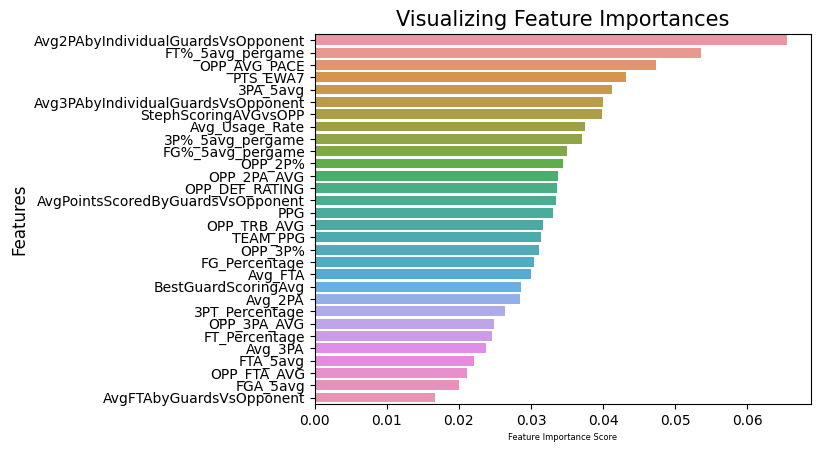

In [44]:
feature_imp = pd.Series(model.feature_importances_, 
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score', fontsize=6)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)
plt.show()

## 2.3 SHAP Feature Importance

In [45]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

PermutationExplainer explainer: 183it [00:28,  4.49it/s]                         


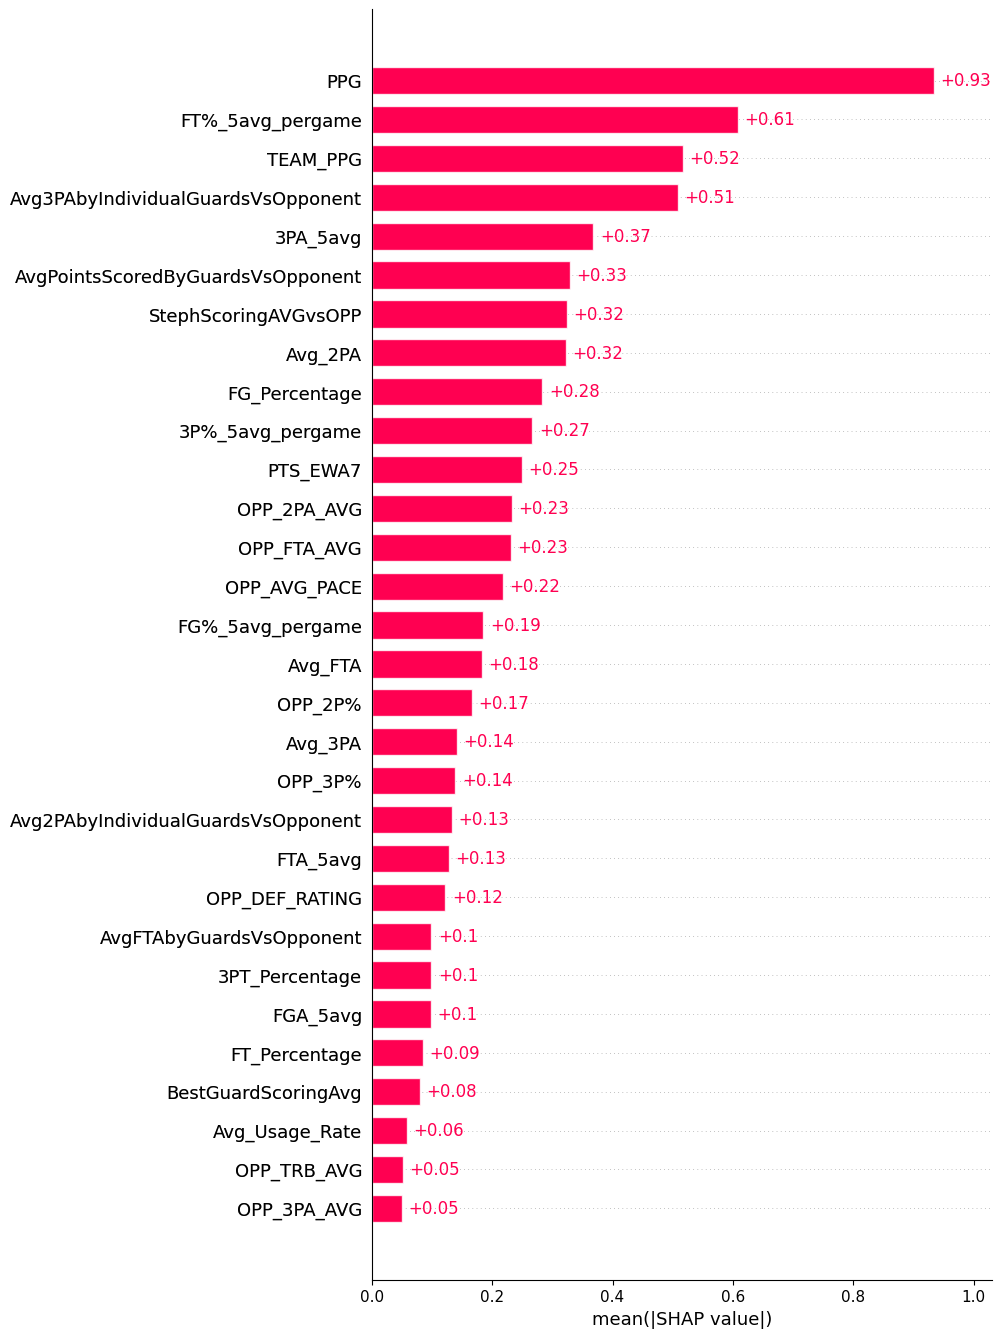

In [46]:
shap.plots.bar(shap_values,  max_display=X_test.shape[1])

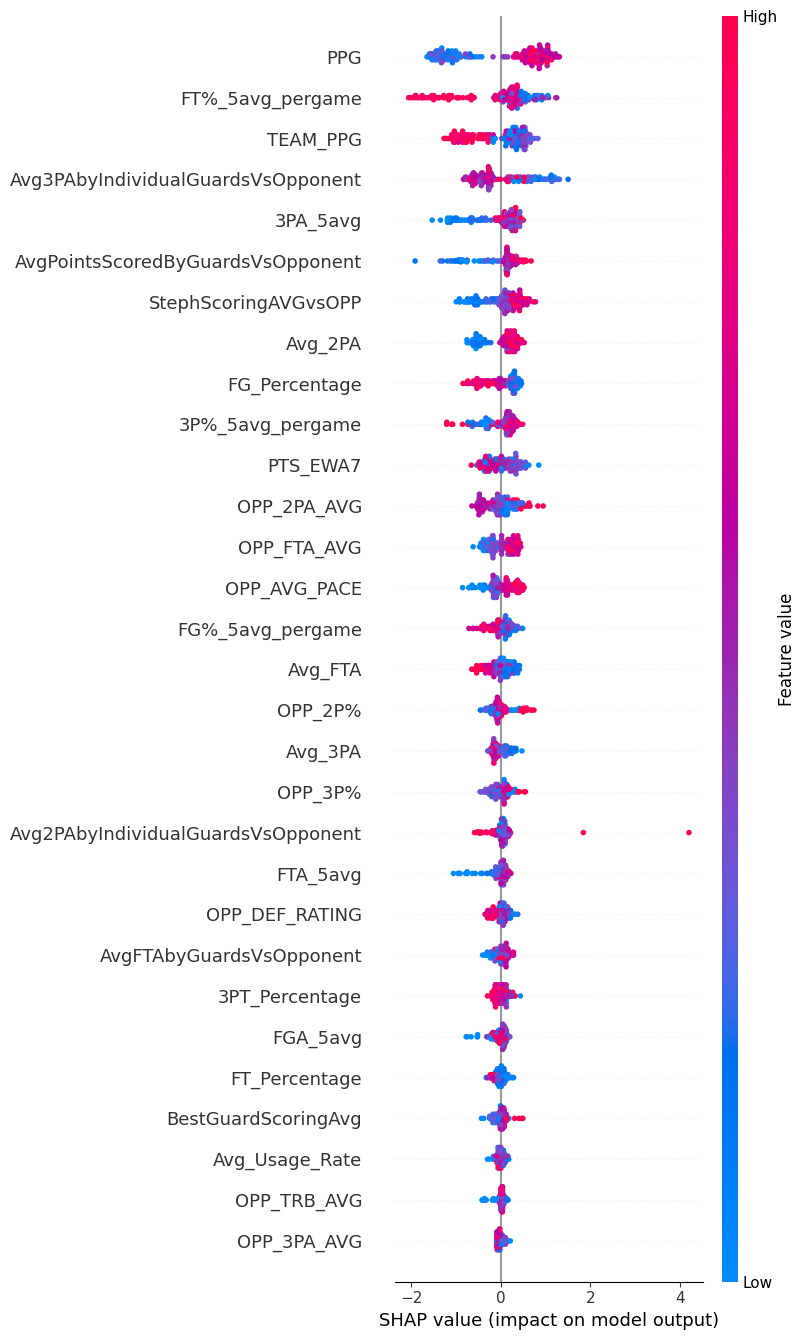

In [47]:
shap.summary_plot(shap_values, max_display=X_test.shape[1])

In [50]:
shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
0,PPG,0.934217
13,FT%_5avg_pergame,0.607819
15,TEAM_PPG,0.516699
27,Avg3PAbyIndividualGuardsVsOpponent,0.508795
8,3PA_5avg,0.368249
25,AvgPointsScoredByGuardsVsOpponent,0.329483
29,StephScoringAVGvsOPP,0.323768
1,Avg_2PA,0.322965
5,FG_Percentage,0.283427
9,3P%_5avg_pergame,0.266595
